In [182]:
import scanpy as sc
from scprocessing.Pipeline import Pipeline
from scprocessing.QC import QC
from scprocessing.Normalization import Normalization
from scprocessing.Integration import Integration
from scprocessing.metrics import jaccard, silhouette, davies, calinski, evaluate
from scprocessing.SelectPipeline import SelectPipeline

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# paths
nsg_bus_1 = "/mnt/shared/nationwide/Counts/NSG_BUS_1/outs/filtered_feature_bc_matrix.h5"
nsg_bus_2 = "/mnt/shared/nationwide/Counts/NSG_BUS_2/outs/filtered_feature_bc_matrix.h5"
nsg_bus_3 = "/mnt/shared/nationwide/Counts/NSG_BUS_3/outs/filtered_feature_bc_matrix.h5"

nsg_ctl_1 = "/mnt/shared/nationwide/Counts/NSG_CNTL_1/outs/filtered_feature_bc_matrix.h5"
nsg_ctl_2 = "/mnt/shared/nationwide/Counts/NSG_CNTL_2/outs/filtered_feature_bc_matrix.h5"
nsg_ctl_3 = "/mnt/shared/nationwide/Counts/NSG_CNTL_3/outs/filtered_feature_bc_matrix.h5"

nsg_s_bus_1 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_1/outs/filtered_feature_bc_matrix.h5"
nsg_s_bus_2 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_2/outs/filtered_feature_bc_matrix.h5"
nsg_s_bus_3 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_3/outs/filtered_feature_bc_matrix.h5"

nsg_s_ctl_1 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_1/outs/filtered_feature_bc_matrix.h5"
nsg_s_ctl_2 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_2/outs/filtered_feature_bc_matrix.h5"
nsg_s_ctl_3 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_3/outs/filtered_feature_bc_matrix.h5"

# Reading Datasets

In [3]:
# read data
nsg_bus_1_data = sc.read_10x_h5(nsg_bus_1)
nsg_bus_2_data = sc.read_10x_h5(nsg_bus_2)
nsg_bus_3_data = sc.read_10x_h5(nsg_bus_3)

# creating metadata
nsg_bus_1_data.obs["Trial"] = "1"
nsg_bus_2_data.obs["Trial"] = "2"
nsg_bus_3_data.obs["Trial"] = "3"

# making names unique
nsg_bus_1_data.var_names_make_unique()
nsg_bus_2_data.var_names_make_unique()
nsg_bus_3_data.var_names_make_unique()

nsg_bus_1_data.obs_names_make_unique()
nsg_bus_2_data.obs_names_make_unique()
nsg_bus_3_data.obs_names_make_unique()

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

In [4]:
nsg_ctl_1_data = sc.read_10x_h5(nsg_ctl_1)
nsg_ctl_2_data = sc.read_10x_h5(nsg_ctl_2)
nsg_ctl_3_data = sc.read_10x_h5(nsg_ctl_3)

nsg_ctl_1_data.obs["Trial"] = "1"
nsg_ctl_2_data.obs["Trial"] = "2"
nsg_ctl_3_data.obs["Trial"] = "3"

nsg_ctl_1_data.var_names_make_unique()
nsg_ctl_2_data.var_names_make_unique()
nsg_ctl_3_data.var_names_make_unique()

nsg_ctl_1_data.obs_names_make_unique()
nsg_ctl_2_data.obs_names_make_unique()
nsg_ctl_3_data.obs_names_make_unique()

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

In [5]:
nsg_s_bus_1_data = sc.read_10x_h5(nsg_s_bus_1)
nsg_s_bus_2_data = sc.read_10x_h5(nsg_s_bus_2)
nsg_s_bus_3_data = sc.read_10x_h5(nsg_s_bus_3)

nsg_s_bus_1_data.obs["Trial"] = "1"
nsg_s_bus_2_data.obs["Trial"] = "2"
nsg_s_bus_3_data.obs["Trial"] = "3"

nsg_s_bus_1_data.var_names_make_unique()
nsg_s_bus_2_data.var_names_make_unique()
nsg_s_bus_3_data.var_names_make_unique()

nsg_s_bus_1_data.obs_names_make_unique()
nsg_s_bus_2_data.obs_names_make_unique()
nsg_s_bus_3_data.obs_names_make_unique()

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

In [6]:
nsg_s_ctl_1_data = sc.read_10x_h5(nsg_ctl_1)
nsg_s_ctl_2_data = sc.read_10x_h5(nsg_ctl_2)
nsg_s_ctl_3_data = sc.read_10x_h5(nsg_ctl_3)

nsg_s_ctl_1_data.obs["Trial"] = "1"
nsg_s_ctl_2_data.obs["Trial"] = "2"
nsg_s_ctl_3_data.obs["Trial"] = "3"

nsg_s_ctl_1_data.var_names_make_unique()
nsg_s_ctl_2_data.var_names_make_unique()
nsg_s_ctl_3_data.var_names_make_unique()

nsg_s_ctl_1_data.obs_names_make_unique()
nsg_s_ctl_2_data.obs_names_make_unique()
nsg_s_ctl_3_data.obs_names_make_unique()

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

In [237]:
# human_brca = sc.read_h5ad("/mnt/shared/nationwide/cell_type_datasets/human_brca.h5ad")
human_brca_stroma = sc.read_h5ad("/mnt/shared/nationwide/cell_type_datasets/human_brca_stroma.h5ad")
human_brca_epithelial = sc.read_h5ad("/mnt/shared/nationwide/cell_type_datasets/human_brca_epithelial.h5ad")
human_brca_immune = sc.read_h5ad("/mnt/shared/nationwide/cell_type_datasets/human_brca_immune.h5ad")
human_brca_global = sc.read_h5ad("/mnt/shared/nationwide/cell_type_datasets/human_brca_global.h5ad")

In [274]:
human_brca.var_names_make_unique()
human_brca.obs_names_make_unique()

human_brca_stroma.var_names_make_unique()
human_brca_stroma.obs_names_make_unique()

human_brca_epithelial.var_names_make_unique()
human_brca_epithelial.obs_names_make_unique()

human_brca_immune.var_names_make_unique()
human_brca_immune.obs_names_make_unique()

human_brca_global.var_names_make_unique()
human_brca_global.obs_names_make_unique()

human_brca_epithelial.obs["Type"] = "Epithelial"
human_brca_stroma.obs["Type"] = "stroma"
human_brca_immune.obs["Type"] = "immune"
human_brca_global.obs["Type"] = "global"

# Run Pipeline

In [132]:
preprocess = Pipeline()
preprocess.add_step(QC())
preprocess.add_step(Normalization(method="zheng17"))
preprocess.add_step(Integration(method="merge"))
integrated = preprocess.execute([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data])

Quality Control
Normalizing Datasets
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-05-09 16:10:04,943 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-09 16:10:13,916 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-09 16:10:13,987 - harmonypy - INFO - Iteration 1 of 10
2024-05-09 16:10:16,332 - harmonypy - INFO - Iteration 2 of 10
2024-05-09 16:10:18,697 - harmonypy - INFO - Converged after 2 iterations


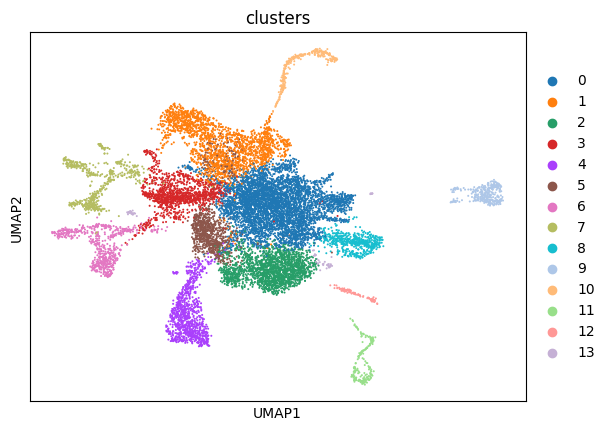

In [134]:
preprocess = Pipeline()
preprocess.add_step(QC())
preprocess.add_step(Normalization(method="seurat"))
preprocess.add_step(Integration(method="harmony"))
harmony = preprocess.execute([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data])

In [ ]:
preprocess = Pipeline()
preprocess.add_step(QC())
preprocess.add_step(Normalization(method="seurat"))
preprocess.add_step(Integration(method="merge"))
sctransform = preprocess.execute([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data])

Quality Control
Normalizing Datasets
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Processing datasets 1 <=> 2
Processing datasets 2 <=> 3
Processing datasets 1 <=> 3


/home/user/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


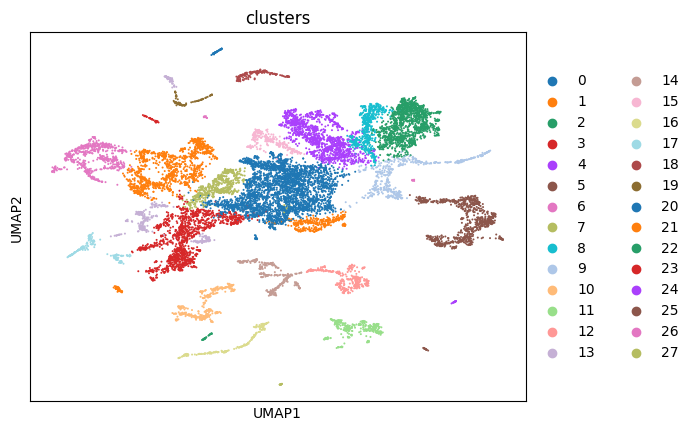

In [39]:
preprocess = Pipeline()
preprocess.add_step(QC())
preprocess.add_step(Normalization())
preprocess.add_step(Integration(method="scanorama"))
scanorama = preprocess.execute([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data])

# Metrics

In [140]:
evaluate(integrated, key="clusters")

jaccard
silhouette
davies
calinski


[0.9991045817102163, 0.027899614, 2.713938509225196, 473.7523519729654]

In [141]:
evaluate(harmony, "clusters")

jaccard
silhouette
davies
calinski


[0.9947450334722553, -0.003565091, 2.415982333596569, 849.2674682905991]

# Model Selection

In [255]:
select = SelectPipeline(normalization=["zheng17", "seurat"], integration=["merge", "harmony", "scanoram"])

Normalizing Datasets
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


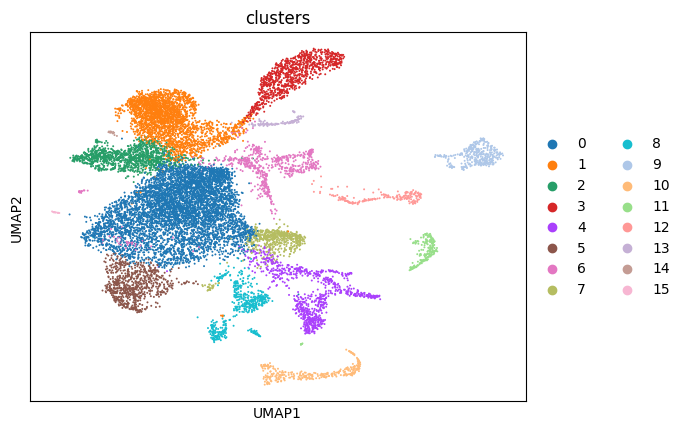

jaccard
silhouette
davies
calinski
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-05-10 22:07:11,855 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-10 22:07:21,694 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-10 22:07:21,741 - harmonypy - INFO - Iteration 1 of 10
2024-05-10 22:07:24,188 - harmonypy - INFO - Iteration 2 of 10
2024-05-10 22:07:26,423 - harmonypy - INFO - Iteration 3 of 10
2024-05-10 22:07:28,503 - harmonypy - INFO - Iteration 4 of 10
2024-05-10 22:07:30,195 - harmonypy - INFO - Iteration 5 of 10
2024-05-10 22:07:31,732 - harmonypy - INFO - Iteration 6 of 10
2024-05-10 22:07:33,914 - harmonypy - INFO - Iteration 7 of 10
2024-05-10 22:07:34,990 - harmonypy - INFO - Iteration 8 of 10
2024-05-10 22:07:36,090 - harmonypy - INFO - Converged after 8 iterations


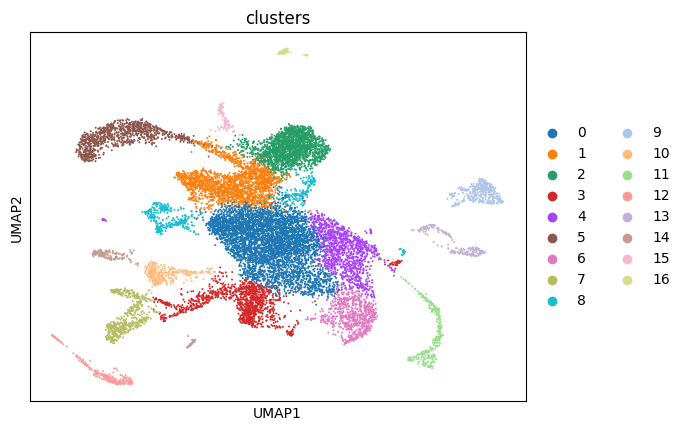

jaccard
silhouette
davies
calinski
Normalizing Datasets


/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:68: UserWarning: Error occured while using zheng17 normalization and scanoram integration: Invalid Integration Method
  warnings.warn(
/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:71: UserWarning: Skipping zheng17 normalization and scanoram integration
  warnings.warn(


Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
report_nsg_s_ctl, pipeline_nsg_s_ctl = select.search([nsg_ctl_1_data, nsg_ctl_2_data, nsg_ctl_3_data])

2024-05-10 22:10:20,981 - harmonypy - INFO - Iteration 2 of 10
2024-05-10 22:10:23,437 - harmonypy - INFO - Iteration 3 of 10
2024-05-10 22:10:26,064 - harmonypy - INFO - Iteration 4 of 10
2024-05-10 22:10:27,534 - harmonypy - INFO - Iteration 5 of 10
2024-05-10 22:10:29,059 - harmonypy - INFO - Iteration 6 of 10
2024-05-10 22:10:31,274 - harmonypy - INFO - Iteration 7 of 10
2024-05-10 22:10:32,517 - harmonypy - INFO - Iteration 8 of 10
2024-05-10 22:10:33,811 - harmonypy - INFO - Converged after 8 iterations


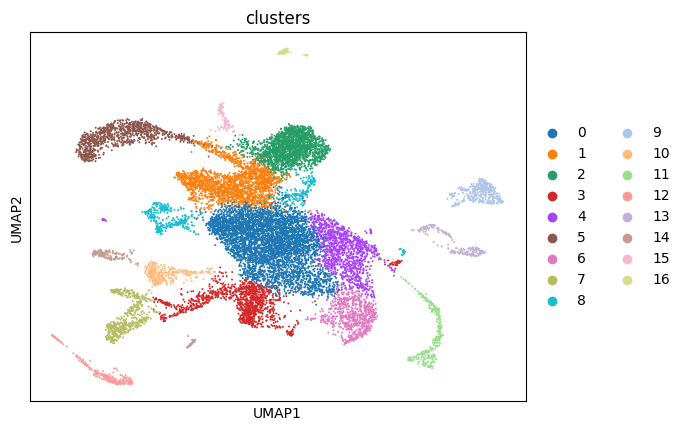

jaccard
silhouette
davies
calinski
Normalizing Datasets


/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:68: UserWarning: Error occured while using zheng17 normalization and scanoram integration: Invalid Integration Method
  warnings.warn(
/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:71: UserWarning: Skipping zheng17 normalization and scanoram integration
  warnings.warn(


Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


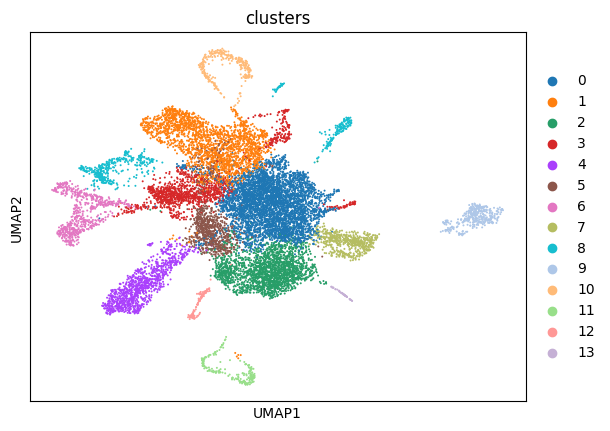

jaccard
silhouette
davies
calinski
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-05-10 22:11:44,502 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-10 22:11:54,573 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-10 22:11:54,622 - harmonypy - INFO - Iteration 1 of 10
2024-05-10 22:11:57,257 - harmonypy - INFO - Iteration 2 of 10
2024-05-10 22:11:59,839 - harmonypy - INFO - Converged after 2 iterations


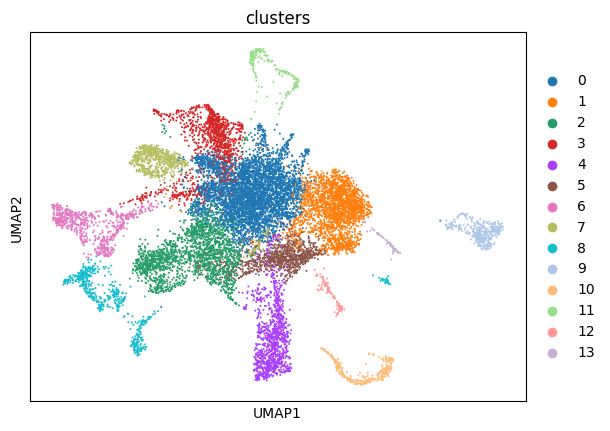

jaccard
silhouette
davies
calinski
      zheng17                  seurat            
        merge     harmony       merge     harmony
0    0.998283    0.998599    0.994969    0.995249
1    0.030454    0.029632   -0.010566   -0.011836
2    2.675973    2.871118    2.428602    2.460319
3  481.552202  480.681769  848.930445  838.767839
4   34.762731   62.514503   29.087291   47.479638


/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:68: UserWarning: Error occured while using seurat normalization and scanoram integration: Invalid Integration Method
  warnings.warn(
/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:71: UserWarning: Skipping seurat normalization and scanoram integration
  warnings.warn(


In [257]:
report_nsg_ctl, pipeline_nsg_ctl = select.search([nsg_ctl_1_data, nsg_ctl_2_data, nsg_ctl_3_data])

Normalizing Datasets
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


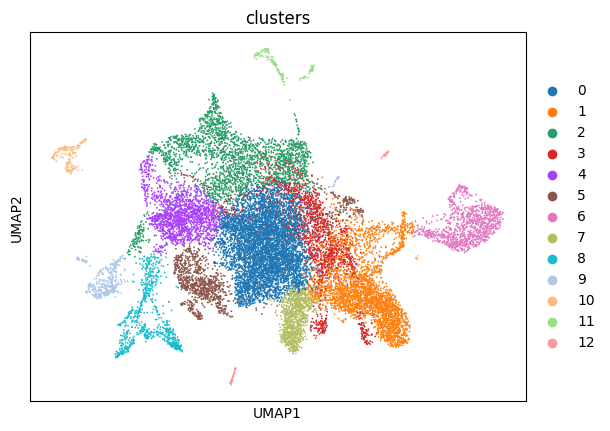

jaccard
silhouette
davies
calinski
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-05-10 22:13:05,858 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-10 22:13:15,916 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-10 22:13:15,967 - harmonypy - INFO - Iteration 1 of 10
2024-05-10 22:13:20,249 - harmonypy - INFO - Iteration 2 of 10
2024-05-10 22:13:24,088 - harmonypy - INFO - Iteration 3 of 10
2024-05-10 22:13:27,613 - harmonypy - INFO - Iteration 4 of 10
2024-05-10 22:13:29,207 - harmonypy - INFO - Iteration 5 of 10
2024-05-10 22:13:30,311 - harmonypy - INFO - Iteration 6 of 10
2024-05-10 22:13:31,522 - harmonypy - INFO - Iteration 7 of 10
2024-05-10 22:13:32,735 - harmonypy - INFO - Converged after 7 iterations


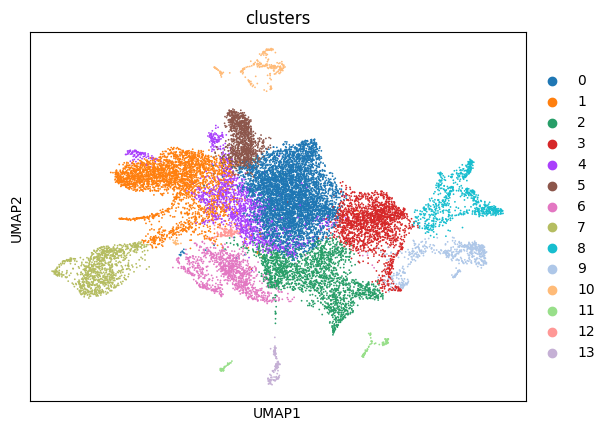

jaccard
silhouette
davies
calinski
Normalizing Datasets


/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:68: UserWarning: Error occured while using zheng17 normalization and scanoram integration: Invalid Integration Method
  warnings.warn(
/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:71: UserWarning: Skipping zheng17 normalization and scanoram integration
  warnings.warn(


Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


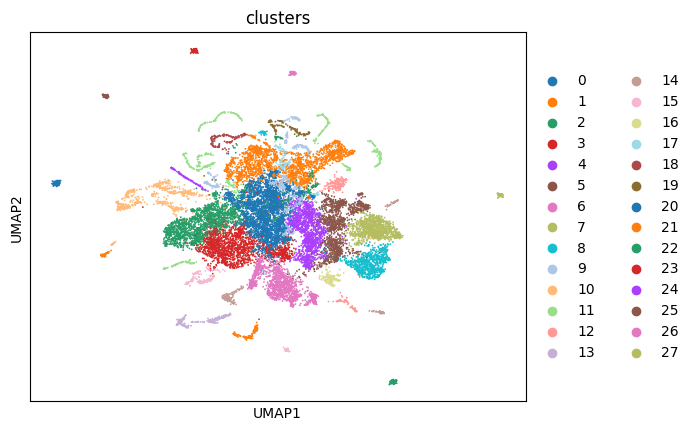

jaccard
silhouette
davies
calinski
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-05-10 22:15:02,911 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-10 22:15:13,117 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-10 22:15:13,175 - harmonypy - INFO - Iteration 1 of 10
2024-05-10 22:15:16,601 - harmonypy - INFO - Iteration 2 of 10
2024-05-10 22:15:20,552 - harmonypy - INFO - Iteration 3 of 10
2024-05-10 22:15:23,903 - harmonypy - INFO - Iteration 4 of 10
2024-05-10 22:15:25,165 - harmonypy - INFO - Iteration 5 of 10
2024-05-10 22:15:27,307 - harmonypy - INFO - Iteration 6 of 10
2024-05-10 22:15:29,368 - harmonypy - INFO - Iteration 7 of 10
2024-05-10 22:15:31,551 - harmonypy - INFO - Iteration 8 of 10
2024-05-10 22:15:33,405 - harmonypy - INFO - Iteration 9 of 10
2024-05-10 22:15:34,709

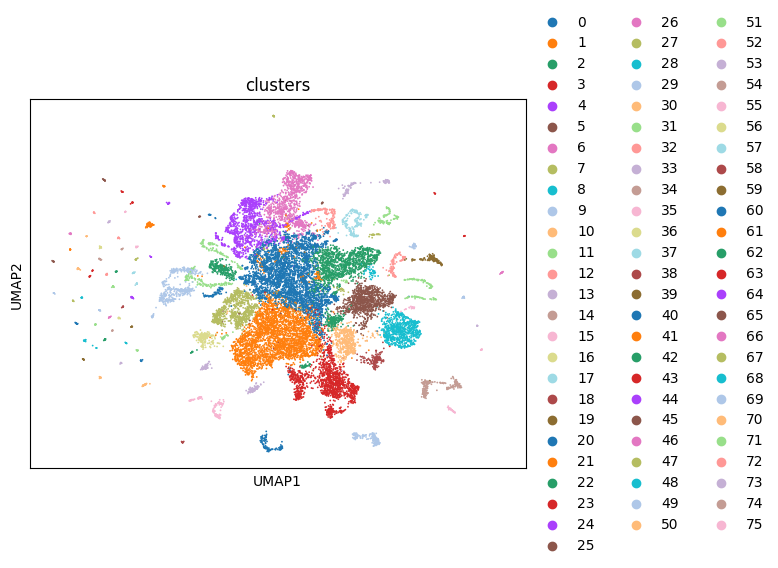

jaccard
silhouette
davies
calinski
      zheng17                  seurat            
        merge     harmony       merge     harmony
0    0.999234    0.998700    0.943625    0.767131
1   -0.019043   -0.018402   -0.168938   -0.162795
2    3.579296    3.593811    3.443571    5.469139
3  414.719495  377.471863  374.556166  152.422711
4   27.872916   61.476945   47.857618   74.090641


/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:68: UserWarning: Error occured while using seurat normalization and scanoram integration: Invalid Integration Method
  warnings.warn(
/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:71: UserWarning: Skipping seurat normalization and scanoram integration
  warnings.warn(


In [258]:
report_nsg_bus, pipeline_nsg_bus = select.search([nsg_bus_1_data, nsg_bus_2_data, nsg_bus_3_data])

Normalizing Datasets
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


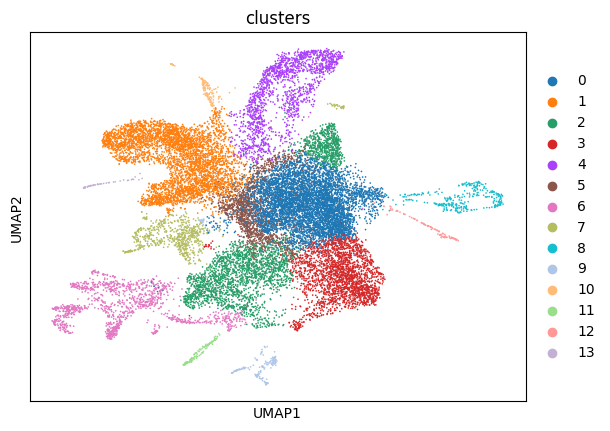

jaccard
silhouette
davies
calinski
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-05-10 22:17:12,594 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-10 22:17:22,471 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-10 22:17:22,527 - harmonypy - INFO - Iteration 1 of 10
2024-05-10 22:17:25,458 - harmonypy - INFO - Iteration 2 of 10
2024-05-10 22:17:28,906 - harmonypy - INFO - Iteration 3 of 10
2024-05-10 22:17:34,089 - harmonypy - INFO - Iteration 4 of 10
2024-05-10 22:17:36,900 - harmonypy - INFO - Iteration 5 of 10
2024-05-10 22:17:40,254 - harmonypy - INFO - Iteration 6 of 10
2024-05-10 22:17:45,197 - harmonypy - INFO - Iteration 7 of 10
2024-05-10 22:17:46,968 - harmonypy - INFO - Iteration 8 of 10
2024-05-10 22:17:48,383 - harmonypy - INFO - Converged after 8 iterations


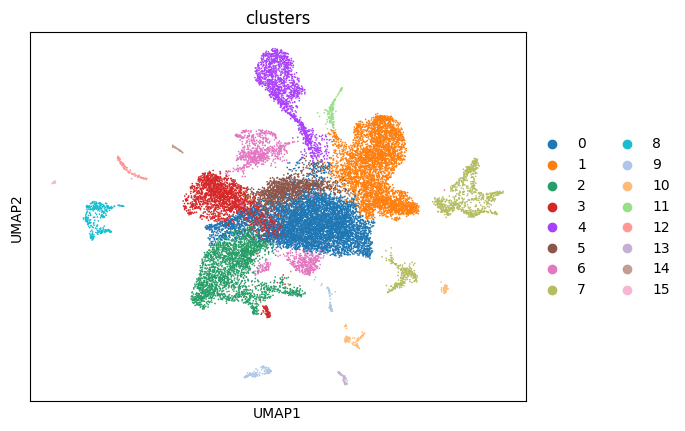

jaccard
silhouette
davies
calinski
Normalizing Datasets


/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:68: UserWarning: Error occured while using zheng17 normalization and scanoram integration: Invalid Integration Method
  warnings.warn(
/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:71: UserWarning: Skipping zheng17 normalization and scanoram integration
  warnings.warn(


Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


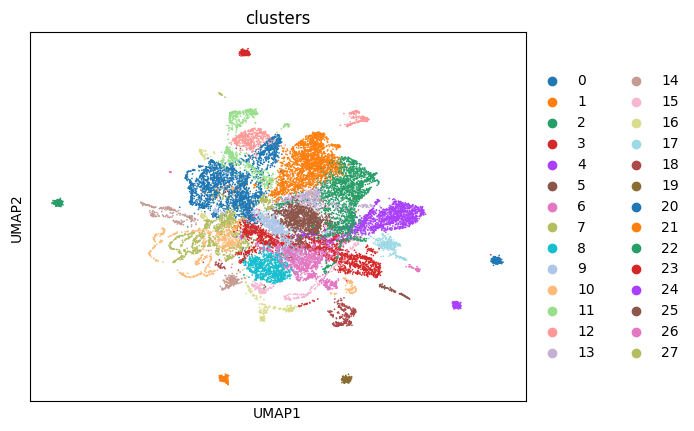

jaccard
silhouette
davies
calinski
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-05-10 22:19:17,329 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-10 22:19:27,839 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-10 22:19:27,986 - harmonypy - INFO - Iteration 1 of 10
2024-05-10 22:19:31,944 - harmonypy - INFO - Iteration 2 of 10
2024-05-10 22:19:35,183 - harmonypy - INFO - Iteration 3 of 10
2024-05-10 22:19:38,956 - harmonypy - INFO - Iteration 4 of 10
2024-05-10 22:19:42,225 - harmonypy - INFO - Iteration 5 of 10
2024-05-10 22:19:48,434 - harmonypy - INFO - Iteration 6 of 10
2024-05-10 22:19:49,743 - harmonypy - INFO - Iteration 7 of 10
2024-05-10 22:19:51,167 - harmonypy - INFO - Iteration 8 of 10
2024-05-10 22:19:52,574 - harmonypy - INFO - Iteration 9 of 10
2024-05-10 22:19:53,971

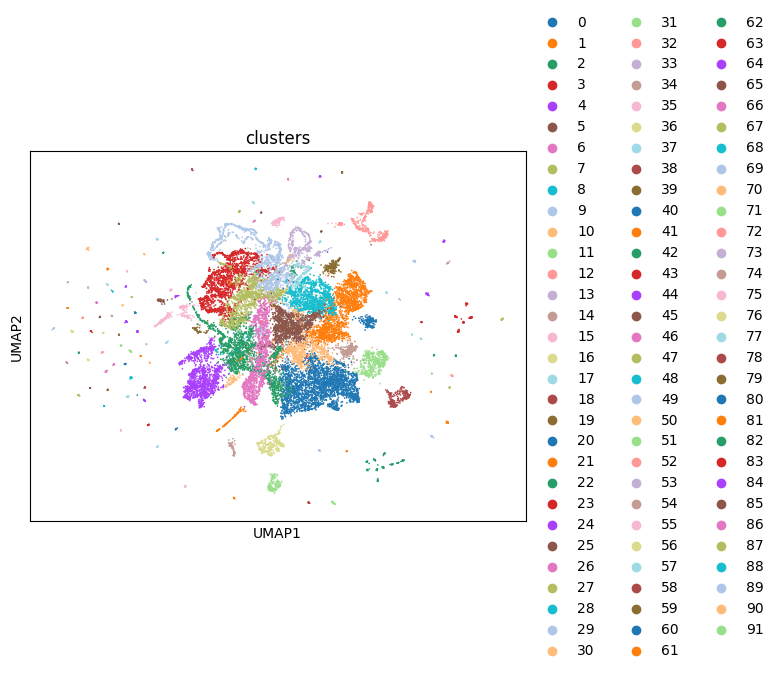

jaccard
silhouette
davies
calinski
      zheng17                  seurat            
        merge     harmony       merge     harmony
0    0.999271    0.998646    0.951221    0.747839
1   -0.033569   -0.032237   -0.181202   -0.193757
2    3.199734    3.150176    5.445296    4.521158
3  459.703181  404.575719  376.166145  116.151434
4   41.385427   74.762262   40.119924  106.539477


/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:68: UserWarning: Error occured while using seurat normalization and scanoram integration: Invalid Integration Method
  warnings.warn(
/home/user/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:71: UserWarning: Skipping seurat normalization and scanoram integration
  warnings.warn(


In [259]:
report_nsg_s_bus, pipeline_nsg_s_bus = select.search([nsg_s_bus_1_data, nsg_s_bus_2_data, nsg_s_bus_3_data])

In [260]:
# report_nsg_s_ctl, report_nsg_s_bus, report_nsg_bus, report_nsg_ctl
print(pipeline_nsg_s_ctl), print(pipeline_nsg_s_bus), print(pipeline_nsg_bus), print(pipeline_nsg_ctl)

SC Pipeline w/ ['zheng17', 'harmony']
SC Pipeline w/ ['zheng17', 'merge']
SC Pipeline w/ ['zheng17', 'merge']
SC Pipeline w/ ['zheng17', 'harmony']


(None, None, None, None)

In [261]:
report_nsg_s_ctl, report_nsg_s_bus, report_nsg_bus, report_nsg_ctl

(                  jaccard  silhouette    davies    calinski    Runtime
 zheng17 merge    0.998283    0.030454  2.675973  481.552202  36.373741
         harmony  0.998599    0.029632  2.871118  480.681769  57.969173
 seurat  merge    0.994969   -0.010566  2.428602  848.930445  30.385017
         harmony  0.995249   -0.011836  2.460319  838.767839  44.079557,
                   jaccard  silhouette    davies    calinski     Runtime
 zheng17 merge    0.999271   -0.033569  3.199734  459.703181   41.385427
         harmony  0.998646   -0.032237  3.150176  404.575719   74.762262
 seurat  merge    0.951221   -0.181202  5.445296  376.166145   40.119924
         harmony  0.747839   -0.193757  4.521158  116.151434  106.539477,
                   jaccard  silhouette    davies    calinski    Runtime
 zheng17 merge    0.999234   -0.019043  3.579296  414.719495  27.872916
         harmony  0.998700   -0.018402  3.593811  377.471863  61.476945
 seurat  merge    0.943625   -0.168938  3.443571  374.556